In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
image_path = "/content/drive/MyDrive/CFL_training_data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
input_images = []
output_images = []
for image in os.listdir(os.path.join(image_path, 'input')):
    input_images.append(cv2.resize(cv2.imread(os.path.join(image_path, 'input', image)), (256,256)))
    output_images.append(cv2.resize(cv2.imread(os.path.join(image_path, 'output_core', image), cv2.IMREAD_GRAYSCALE), (256,256))/255)

In [ ]:
output_images = [image[..., np.newaxis] for image in output_images]

In [ ]:
# Split the dataset into train, test, and validation sets
input_train, input_temp, output_train, output_temp = train_test_split(input_images, output_images, test_size=0.2, random_state=42)
input_val, input_test, output_val, output_test = train_test_split(input_temp, output_temp, test_size=0.5, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate augmented batches of data from directories
train_generator = train_datagen.flow(np.array(input_train), np.array(output_train), batch_size=8)
val_generator = val_datagen.flow(np.array(input_val), np.array(output_val), batch_size=8)
test_generator = test_datagen.flow(np.array(input_test), np.array(output_test), batch_size=8)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def unet_plus_plus(input_shape=(256, 256, 3), num_filters=64):
    inputs = Input(input_shape)

    # Downsampling
    c1 = conv_block(inputs, num_filters)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv_block(p1, num_filters * 2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv_block(p2, num_filters * 4)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv_block(p3, num_filters * 8)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv_block(p4, num_filters * 16)

    # Upsampling
    u6 = Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv_block(u6, num_filters * 8)

    u7 = Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv_block(u7, num_filters * 4)

    u8 = Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv_block(u8, num_filters * 2)

    u9 = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(0.1)(u9)
    c9 = conv_block(u9, num_filters)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)

    #model = Model(inputs=[inputs], outputs=[outputs], name = "U-Net++")
    model = Model(inputs=[inputs], outputs=[outputs], name="U_Net_Plus_Plus")


    return model


In [ ]:
model = unet_plus_plus()
model.summary()

Model: "U_Net_Plus_Plus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normaliz

In [ ]:
import keras.backend as K

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 0.01 * tf.keras.losses.binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.binary_crossentropy, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])
#model.compile(optimizer=Adam(lr=1e-4), loss=dice_p_bce, metrics=['accuracy', dice_coef, mean_iou])

In [ ]:
checkpoint_filepath = os.path.join(image_path, "Unet_plus_plus_{epoch:02d}-{val_loss:.2f}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history=model.fit(x=np.array(input_train),
          y=np.array(output_train),
          validation_data=(np.array(input_val), np.array(output_val)),
          batch_size=8,
          epochs=20,
          callbacks=[model_checkpoint_callback])

Epoch 1/20
180/180 [==============================] - 139s 770ms/step - loss: 0.0517 - dice_coef: 0.9159 - binary_accuracy: 0.9571 - true_positive_rate: 0.9670 - val_loss: 0.0508 - val_dice_coef: 0.9239 - val_binary_accuracy: 0.9564 - val_true_positive_rate: 0.9690
Epoch 2/20
180/180 [==============================] - 134s 743ms/step - loss: 0.0497 - dice_coef: 0.9202 - binary_accuracy: 0.9573 - true_positive_rate: 0.9677 - val_loss: 0.0502 - val_dice_coef: 0.9261 - val_binary_accuracy: 0.9565 - val_true_positive_rate: 0.9732
Epoch 3/20
180/180 [==============================] - 137s 759ms/step - loss: 0.0480 - dice_coef: 0.9235 - binary_accuracy: 0.9576 - true_positive_rate: 0.9677 - val_loss: 0.0482 - val_dice_coef: 0.9254 - val_binary_accuracy: 0.9567 - val_true_positive_rate: 0.9702
Epoch 4/20
180/180 [==============================] - 135s 751ms/step - loss: 0.0484 - dice_coef: 0.9240 - binary_accuracy: 0.9573 - true_positive_rate: 0.9675 - val_loss: 0.0478 - val_dice_coef: 0.9265

In [ ]:
model.save(os.path.join(image_path, 'unet_plus_plus_epochs.hdf5'))

In [ ]:
# Predicting on the test set
pred = model.predict(np.array(input_test))

6/6 [==============================] - 3s 565ms/step


In [ ]:
# Example for checking the statistics of the first predicted image
print('Min:', np.min(pred[0]))
print('Max:', np.max(pred[0]))
print('Mean:', np.mean(pred[0]))
print('Unique values:', np.unique(pred[0]))

Min: 6.360766e-05
Max: 0.99999917
Mean: 0.32745844
Unique values: [6.3607658e-05 6.6555120e-05 6.7224748e-05 ... 9.9999893e-01 9.9999905e-01
 9.9999917e-01]


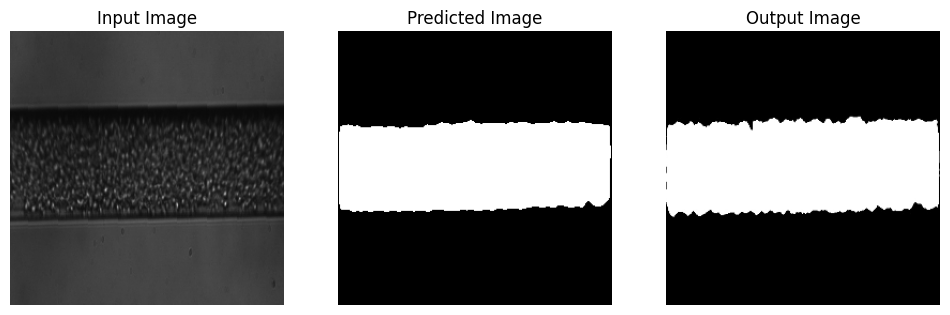

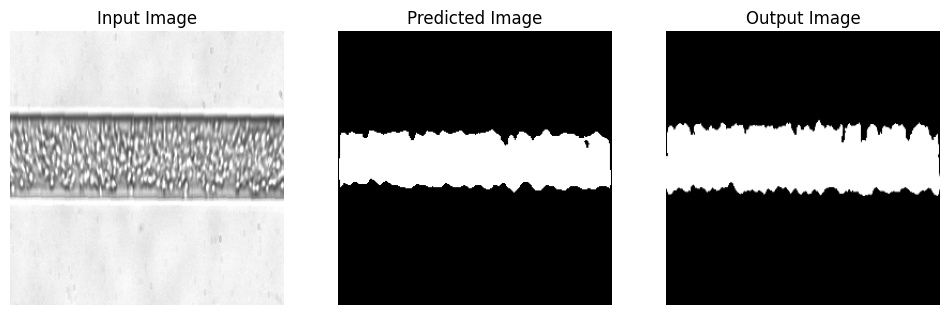

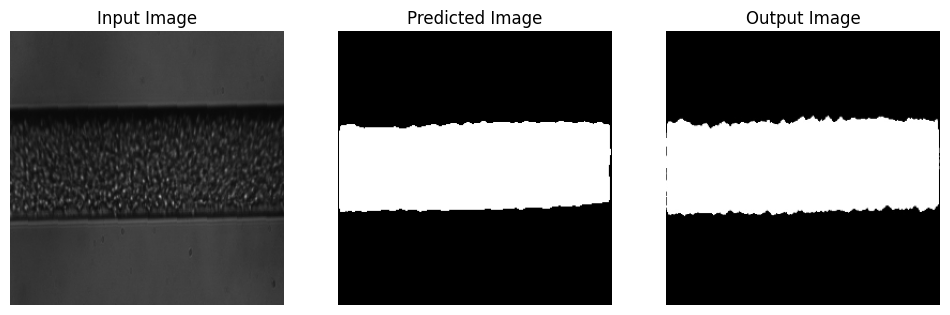

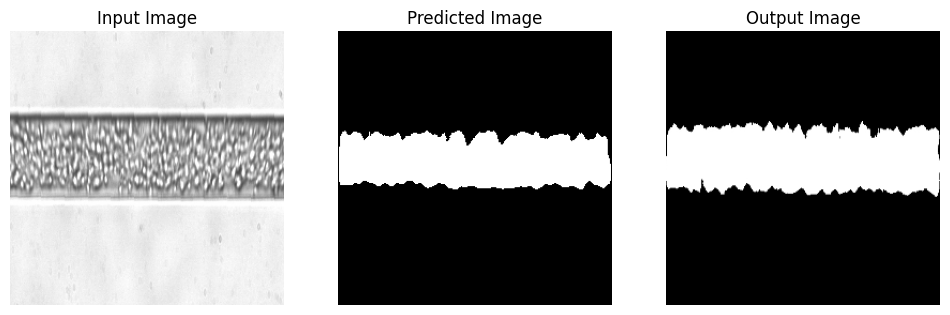

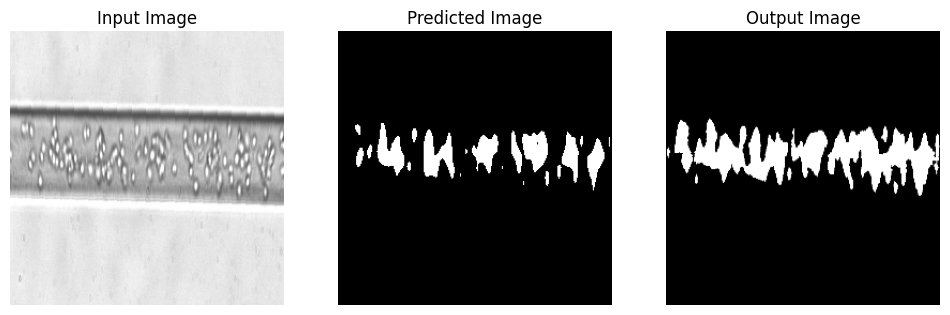

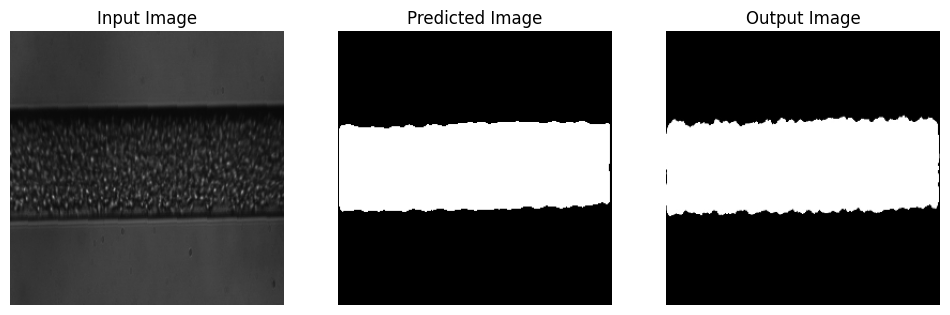

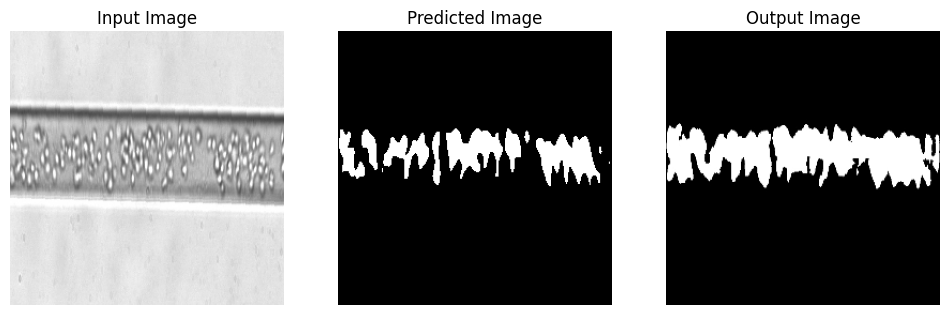

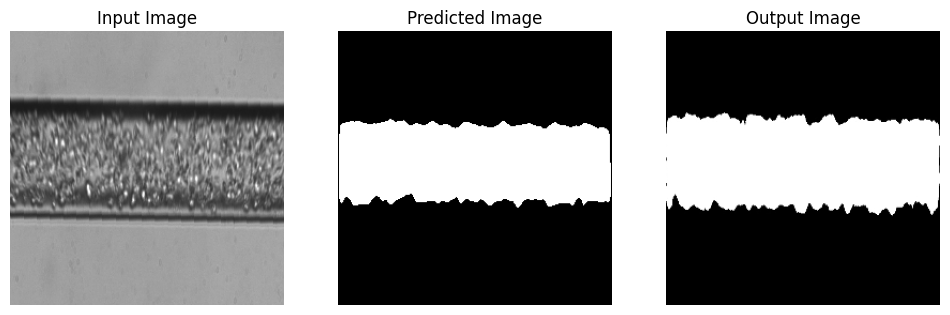

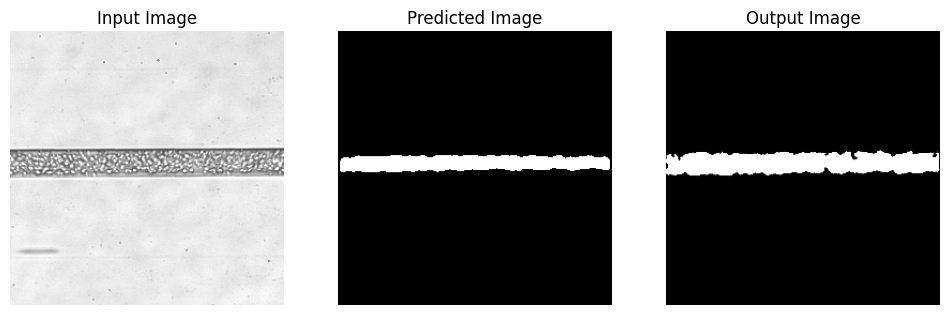

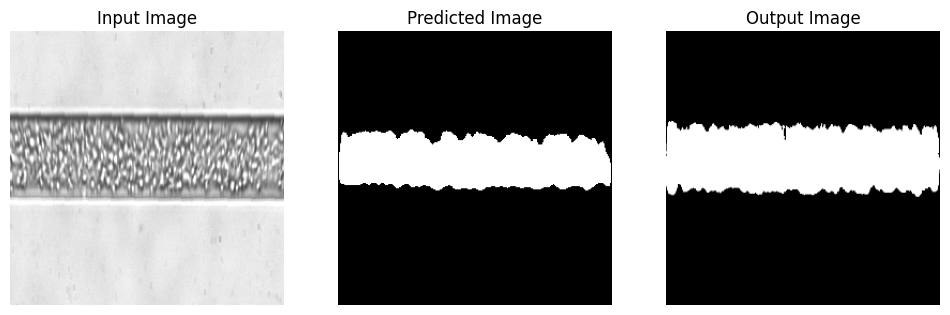

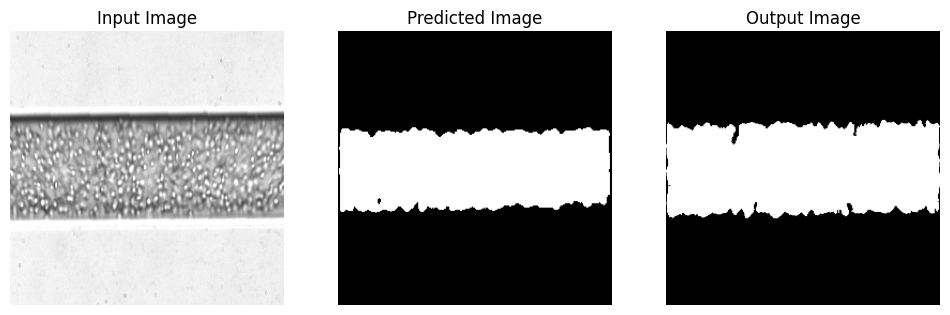

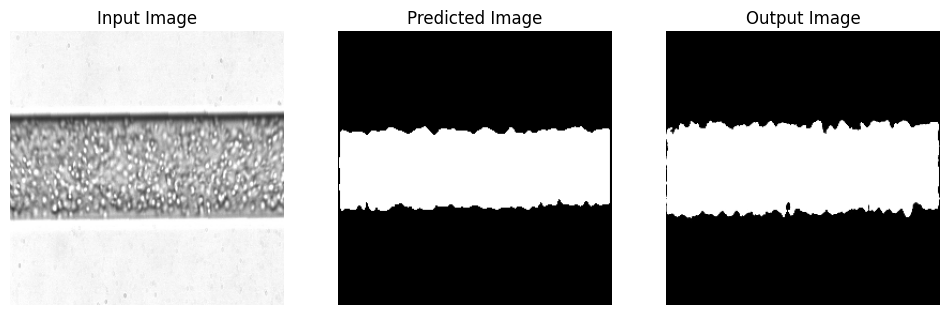

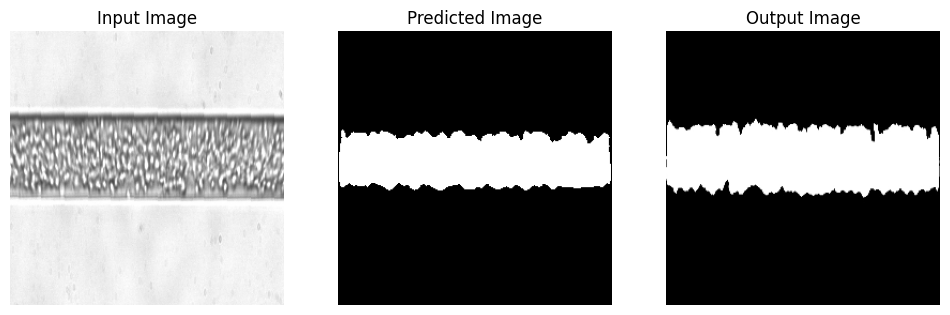

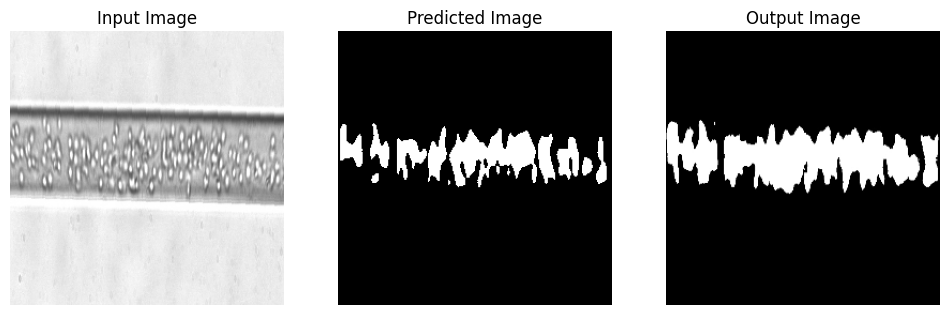

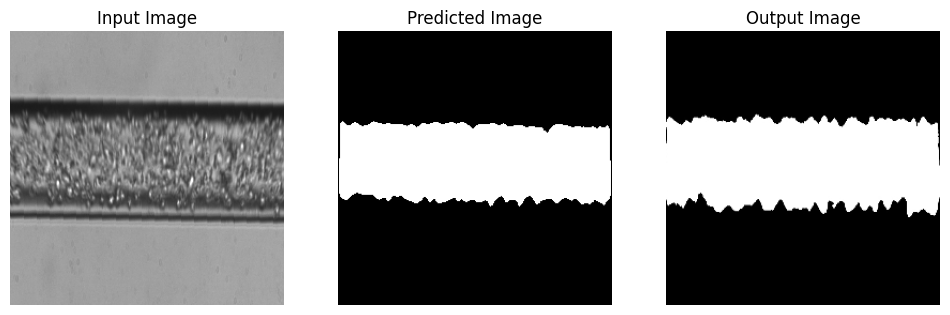

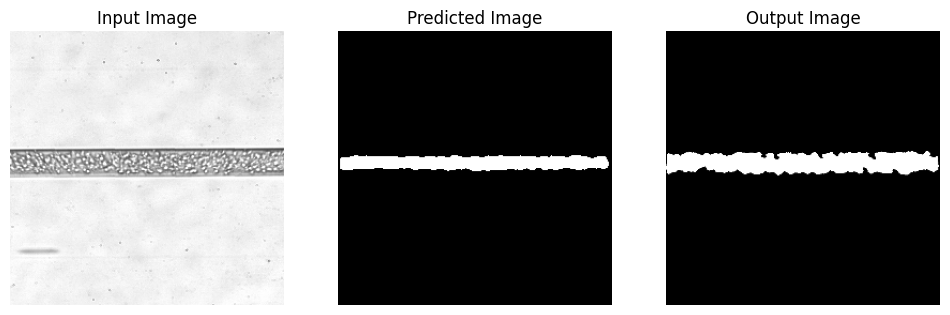

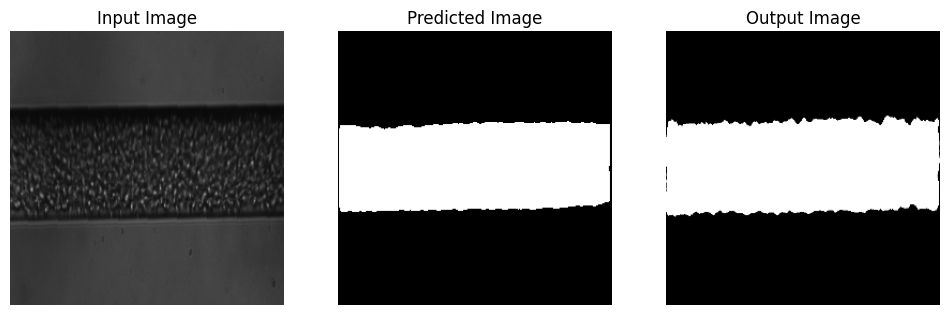

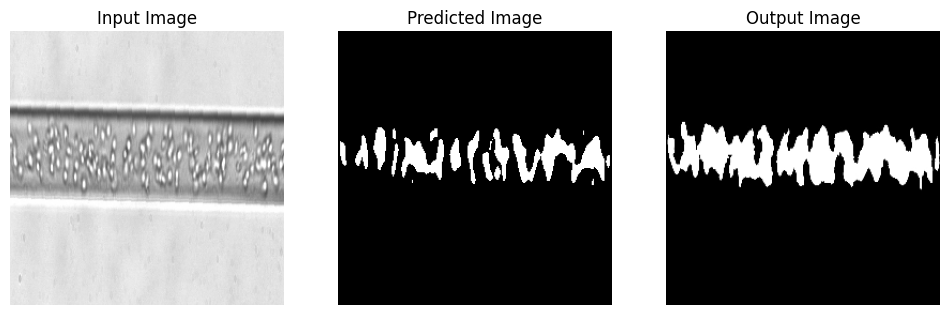

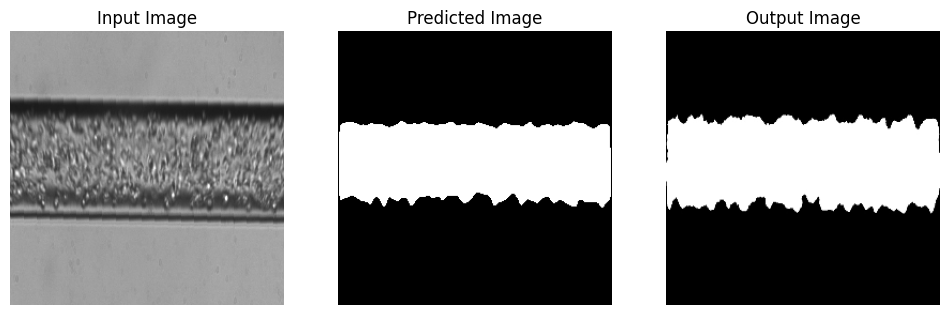

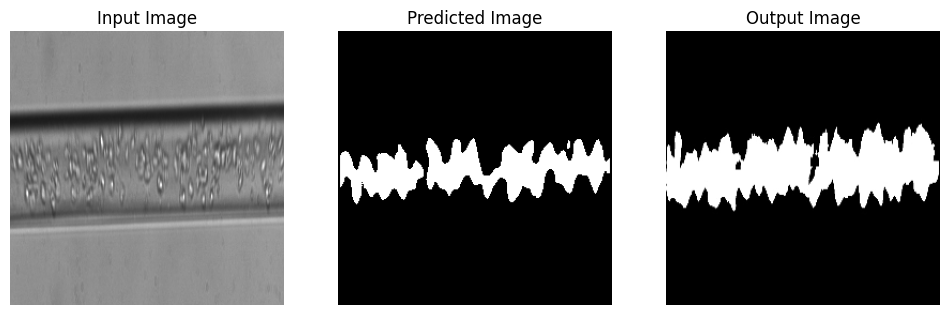

In [ ]:
# Plotting the input, predicted, and output images without threshold
for i in range(len(input_test))[:20]:
    plt.figure(figsize=(12, 6))

    # Display input image
    plt.subplot(1, 3, 1)
    plt.imshow(input_test[i])
    plt.title("Input Image")
    plt.axis('off')

    # Display predicted image without threshold
    plt.subplot(1, 3, 2)
    plt.imshow(pred[i]>0.95, cmap='gray', vmin=0, vmax=1)
    plt.title("Predicted Image")
    plt.axis('off')

    # Display corresponding output image
    plt.subplot(1, 3, 3)
    plt.imshow(output_test[i][:, :, 0], cmap='gray', vmin=0, vmax=1)
    plt.title("Output Image")
    plt.axis('off')

    plt.show()

In [ ]:
def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0

    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

def pixel_wise_accuracy(im1, im2):
    correct_pixels = np.sum(im1 == im2)
    total_pixels = np.prod(im1.shape)
    accuracy = correct_pixels / total_pixels
    return accuracy

In [ ]:
dice_sum = 0
acc_sum = 0
for pred_img, output_img in zip(pred, output_test):
  dice_sum += dice(pred_img>0.8, output_img)
  acc_sum += pixel_wise_accuracy(pred_img>0.9, output_img)

print("DICE: {}".format(dice_sum/len(pred)))
print("Accuracy: {}".format(acc_sum/len(pred)))

DICE: 0.9048921511669955
Accuracy: 0.9458538479275174
